# NL-EIG Reachability Analysis Example

This example demonstrates a complete workflow for reachability verification analysis using the nonlinear system with known eigenpairs.

| Item                             | Description                                                                                                                                                                                                                                    |
| -------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Dynamical System**             | Nonlinear System with Known Eigenpairs                                                                                                                                                                                                         |
| **Dimension**                    | 2D                                                                                                                                                                                                                                             |
| **Expected Verification Result** | Reachable                                                                                                                                                                                                                                      |
| **Eigenpairs**                   | Principal eigenpairs with feasible residuals                                                                                                                                                                                                   |
| **Experiment Objective**         | Extract the system's eigenfunctions through the Residual Dynamic Mode Decomposition (ResDMD) algorithm, and perform reachability bound computation based on these eigenfunctions to verify reachability from the initial set to the target set |


In [1]:
# load the modules

import os
import sys

sys.path.append("../")

import numpy as np

import ddrv

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
/home/jianqiang/Downloads/Residual-Dynamic-Mode-Decomposition-1/examples/../ddrv/viz/vis_vector_field_2d.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


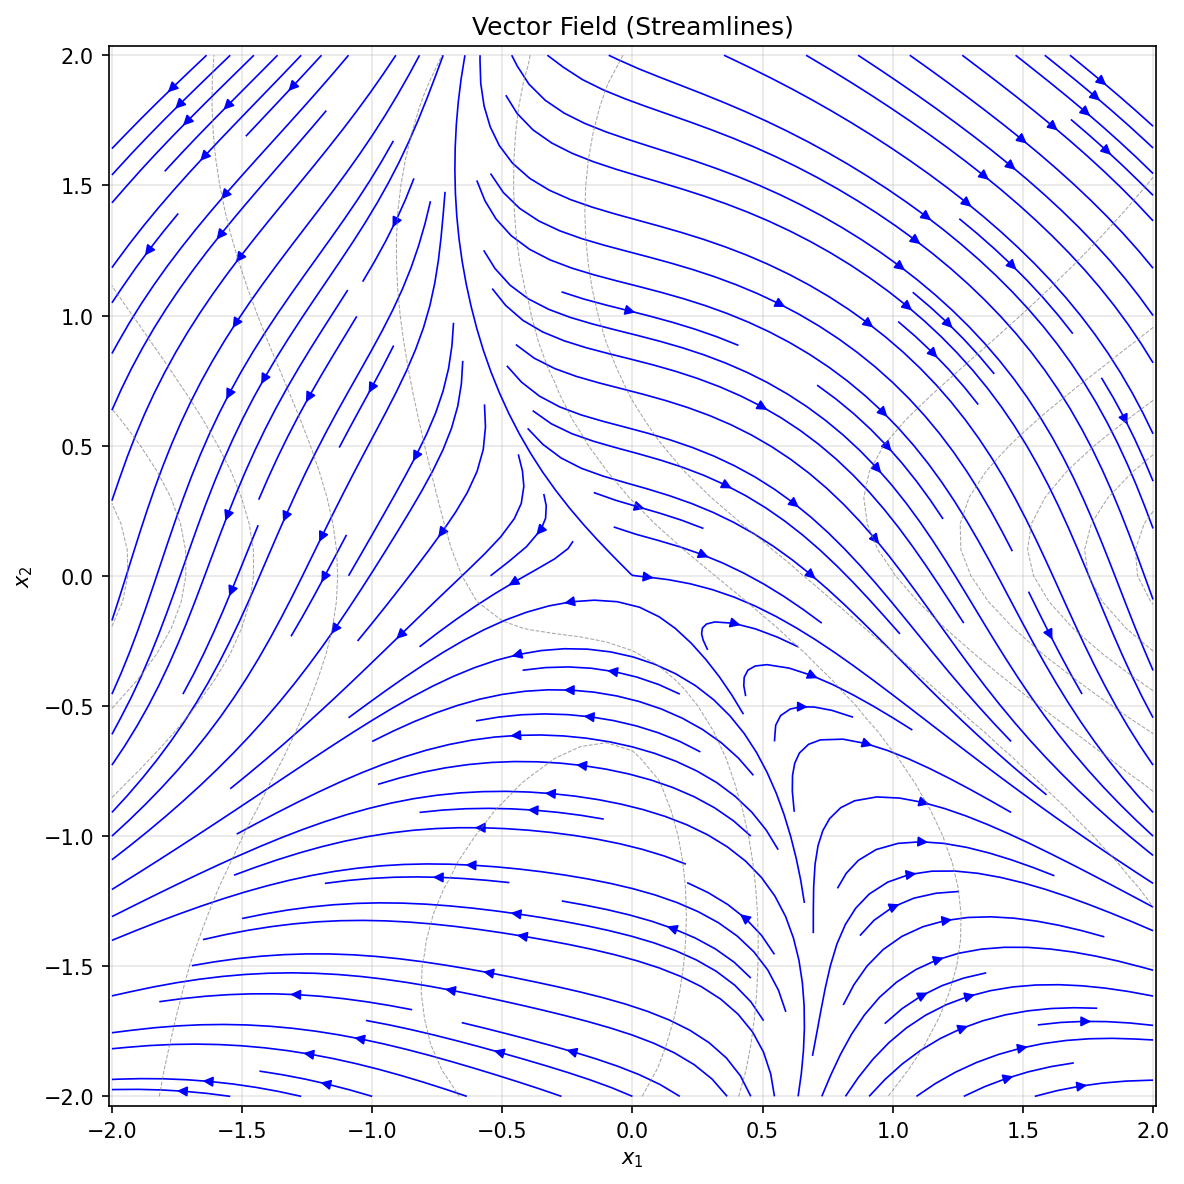

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'center': 'Vector Field (Streamlines)'}, xlabel='$x_1$', ylabel='$x_2$'>)

In [2]:
# define the dynamical system
NL_EIG = ddrv.dynamic.NL_EIG(lambda1=-1.0, lambda2=2.5)
ddrv.viz.vis_vector_field_2d(
    NL_EIG.get_numerical_dynamics(),
    domain=[[-2, 2], [-2, 2]],
    step_size=0.1,
)

generated 1000 trajectories in batch (odeint), 10 steps, 0.05 time step...
(11, 1000, 2)


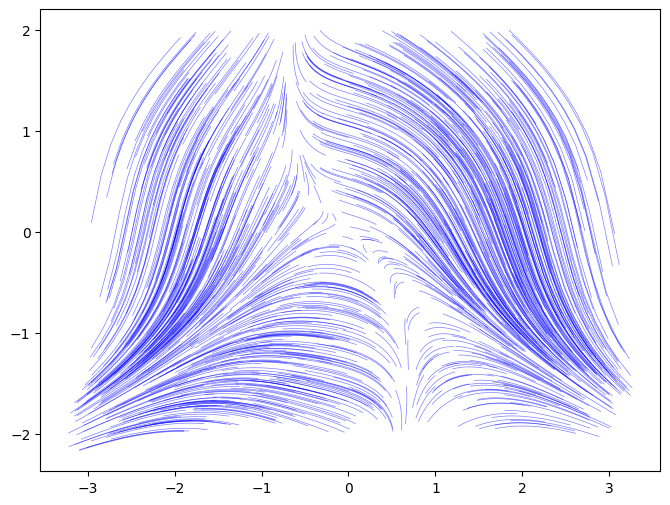

In [3]:
# set the seed for reproducibility
RANDOM_SEED = 42
DELTA_T = 0.05


# generate the trajectory data
traj_data = ddrv.common.generate_trajectory_data(
    NL_EIG,
    num_samples=1000,
    num_steps=10,
    delta_t=DELTA_T,
    domain=[[-2, 2], [-2, 2]],
    random_seed=RANDOM_SEED,
)
print(traj_data.shape)

# visualize the trajectory data
ddrv.viz.vis_trajectory_2d(traj_data)

In [4]:
# now split the trajectory data into X and Y arrays, X refers the current state, Y refers the next state
X = traj_data[:-1, :, :].reshape(-1, 2)
Y = traj_data[1:, :, :].reshape(-1, 2)
print(X.shape, Y.shape)

(10000, 2) (10000, 2)


In [23]:
# get the principal eigenvalues
print(RANDOM_SEED)
LAM_P_dt, LAM_P_ct = ddrv.common.get_principal_eigenvalues(
    NL_EIG,
    [0, 0],
    0.00001,  # radius for the small neighborhood
    num_samples=5000,
    num_steps=10,
    dt=0.01,
    random_seed=RANDOM_SEED,
)

print("discrete time principal eigenvalues", LAM_P_dt)
print("continuous time principal eigenvalues", LAM_P_ct)

42
generated 5000 trajectories in batch (odeint), 10 steps, 0.01 time step...
(50000, 2) (50000, 2)
(2, 2)
discrete time principal eigenvalues [1.02531523 0.99004982]
continuous time principal eigenvalues [ 2.50001083 -1.00000109]


In [6]:
# now apply the resdmd algorithm to get the principal eigenfunctions

L, V, residuals, observables, PX, PY, K = ddrv.algo.resdmd(
    X, Y, observe_params={"basis": "poly", "degree": 9}
)

print(
    L.shape,
    V.shape,
    residuals.shape,
    observables.shape,
)

# define the threshold for the residuals
threshold = 1e-4  # CAUTION: but for larger threshold, the results are not good, like threshold = 1e-2, which is make sense in fact
# get the eigenvalues and eigenvectors with residuals less than the threshold
idx = np.where(residuals < threshold)[0]
print(idx, "idx")
L_feasible_dt = L[idx]  #  these are discrete eigenvalues
# get the continuous eigenvalues
L_feasible_ct = np.log(L_feasible_dt) / DELTA_T
# get the feasible eigenvectors
V_feasible = V[:, idx].T
print(L_feasible_dt.shape, V_feasible.shape)
print(L_feasible_ct, "L_feasible_ct")

PX.shape, V.shape (10000, 55) (55, 55)
(55,) (55, 55) (55,) (2, 55)
[ 6  9 14 15 24 32 39 40 47 51 52] idx
(11,) (11, 55)
[ 7.50835948e+00+0.j  6.66729150e+00+0.j  5.81127932e+00+0.j
  5.00627634e+00+0.j  4.00408925e+00+0.j  2.50000017e+00+0.j
  3.99680289e-14+0.j -3.00000001e+00+0.j -1.99999985e+00+0.j
 -1.00000001e+00+0.j  1.50270246e+00+0.j] L_feasible_ct


generated 3000 trajectories in batch (odeint), 5 steps, 0.05 time step...
(6, 3000, 2)


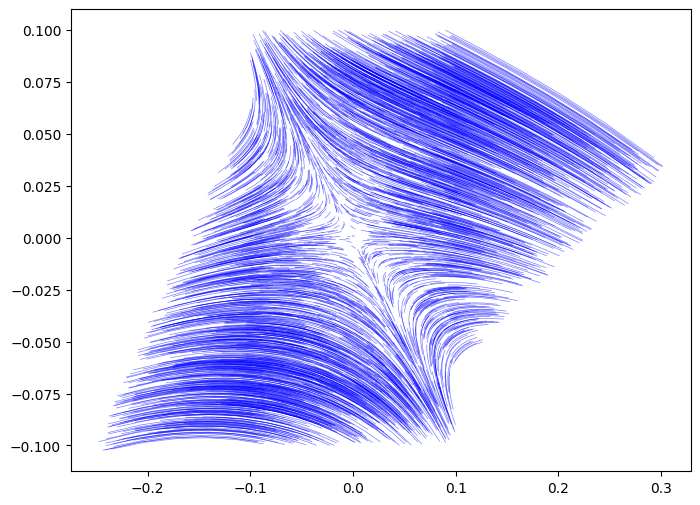

PX.shape, V.shape (15000, 55) (55, 55)
[ 1.24694364e+01+0.j  9.98449752e+00+0.j  8.96399471e+00+0.j
  7.49999274e+00+0.j  6.50004214e+00+0.j  5.47899687e+00+0.j
  4.63662700e+00+0.j  4.99999061e+00+0.j  3.99999781e+00+0.j
 -3.99998569e+00+0.j -2.99999884e+00+0.j  3.00149168e+00+0.j
  2.49999990e+00+0.j -2.00000006e+00+0.j -1.51377130e+00+0.j
  1.50000072e+00+0.j  1.46549439e-13+0.j  4.99999593e-01+0.j
 -5.01695181e-01+0.j -1.00000051e+00+0.j] L_feasible_ct_P


In [7]:
# now generte samples from a small nerighborhood of the hyperbolic equilibrium point, this is for estimating the principal eigenvalues and eigenvectors
# generate the trajectory data
traj_data_small_neighborhood = ddrv.common.generate_trajectory_data(
    NL_EIG,
    domain=[[-0.1, 0.1], [-0.1, 0.1]],
    num_samples=3000,
    num_steps=5,
    delta_t=DELTA_T,
)
print(traj_data_small_neighborhood.shape)

X_small_neighborhood = traj_data_small_neighborhood[:-1, :, :].reshape(-1, 2)
Y_small_neighborhood = traj_data_small_neighborhood[1:, :, :].reshape(-1, 2)

# visualize the trajectory data
ddrv.viz.vis_trajectory_2d(traj_data_small_neighborhood)

L_P, V_P, Res_P, observables_P, PX_P, PY_P, K_P = ddrv.algo.resdmd(
    X_small_neighborhood,
    Y_small_neighborhood,
    observe_params={"basis": "poly", "degree": 9},
)

# get the eigenvalues with residuals less than the threshold
idx_P = np.where(Res_P < 1e-4)[0]
L_feasible_dt_P = L_P[idx_P]
L_feasible_ct_P = np.log(L_feasible_dt_P) / DELTA_T

print(L_feasible_ct_P, "L_feasible_ct_P")